In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from mpl_toolkits import mplot3d




from scipy.special import softmax
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')

In [2]:
def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
       
    
    



def make_adjacency(x,y,r,t,ide,split_id,run):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        for j in range(len(x)):
            if ide[i]==ide[j] and ide[i]!=-2:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
            elif ide[i]==split_id[j]:
                if ide[i]==-1:
                    A[i,j]=1
                elif t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id], fmt='%i',delimiter='\t')
    
    return A
        

    
def make_weighted_adj_estimate(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            A[i,0]=1.5
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=gaus2d(x[j], y[j], x[i], y[i]) #1/((x[i]-x[j])**2+(y[i]-y[j])**2)
            #if i>j:
                #A[i,j]=0
        if np.sum(A[i,:])!=0:
            A[i,:]=mean_normal(A[i,:])
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    
    np.savetxt('./'+str(run)+'/'+'B.txt', A)
    return A
    
    
def make_dist_matrix(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
       
    
    
    np.savetxt('./'+str(run)+'/'+'D.txt', A)
    return A


def make_weighted_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j and j!=0:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    
    
    np.savetxt('./node2vec/graph/'+str(run)+'.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))



def padding(maxlen,run):
    #A,B,E
    
    B=np.loadtxt('./'+str(run)+'/'+'B.txt')
    A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
    E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
    
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):
    
    

In [3]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
#print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)

print(gaus2d(1.8*0.07, 1.8*0.07, 0, 0, sx=0.07, sy=0.07))


A,B,E =padding(7,1)

print(E)

1.2720668358645384
(226, 226)
[[ 0.2667339   0.06286879 -0.23921679 ... -0.07491384 -0.15262282
   0.27217752]
 [ 0.19017881 -0.26520962 -0.42836598 ...  0.15904991 -0.66340786
   0.2128967 ]
 [ 0.43019086  0.40295407  0.00882629 ...  0.2818543   0.16340493
   0.39505556]
 ...
 [ 0.11768251  0.10542036 -0.30013287 ... -0.14902349 -0.13649535
   0.18672603]
 [ 0.32256305  0.03734041 -0.14225286 ... -0.00880912 -0.24637268
   0.22568886]
 [ 0.10639543  0.07344977 -0.25605074 ... -0.02324451 -0.08551909
   0.1247244 ]]


In [4]:
lenA=[]
for i in range(1,15):

    run=i

    x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
    #print(len(x))
    A=make_adjacency(x,y,r,t,ide,split_id,run)
    print(len(A),i)
    lenA.append(len(A))
    
    B=make_weighted_adj_estimate(x,y,t,run)
    #print(B)
    C,e1,e2,w=make_weighted_edgelist(B,run)
    make_true_edgelist(A,run)
    
    make_dist_matrix(x,y,t,run)
    
maxlen=np.max(lenA)
print(maxlen)






226 1
241 2
261 3
199 4
246 5
235 6
212 7
203 8
228 9
225 10
238 11
243 12
239 13
231 14
261


In [5]:
#print(stop)

for i in range(1,15):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    b=b[:,1:]
    
    #pos= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = pos.T[:,5]
    #split_prob = split_prob[:, np.newaxis]
    #r = pos.T[:,2]
    #r=r[:, np.newaxis]
    
    #print(b.shape,pos.shape)
    
    #b=np.append(b,r,axis=1)
    #b=np.append(b,split_prob,axis=1)
    
    #np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    
    
    ##remove below if n2v is used
    
    print(len(b[0]))
    
    #p = np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = p.T[:,5]
    #print(len(split_prob),split_prob)
    #b = b.T[:,0:3]
    #split_prob=split_prob[:, np.newaxis]
    #print(len(b),b)
    
    #print(b.shape,split_prob.shape)
    
    #######b=np.append(b,split_prob,axis=1)
    
    #b=np.append(pos,split_prob,axis=1)
    
    
    #print(b)
    #b=np.repeat(b, 6, axis=1)
    #print(i)
    #print(b)
    
    np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    padding(maxlen,run)
    

24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)
24
(261, 261)


python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

[ 0.0279804   0.64536446  0.04772233 -0.07463184 -0.10536852  0.05506293
  0.5886918   0.35233107  0.04802374 -0.0145262  -0.1813805  -0.22229542
 -0.00323168 -0.03887226 -0.2391123  -0.30326504 -0.28014255 -0.09927475
 -0.3945578  -0.33235055 -0.03043007 -0.25991717  0.08712427 -0.47777227
 -0.19397475 -0.47330186 -0.47641715  0.30472085 -0.12136749 -0.49613976
  0.05495004  0.32959723 -0.47584397 -0.1958504  -0.3643922   0.01258283
 -0.01111241 -0.08233896 -0.2847844   0.43636793  0.42295495  0.07286844
 -0.05381456  0.20580351  0.48074138 -0.11580174  0.50563     0.35283217
  0.5604505   0.13839915  0.39842197  0.29371724  0.5496323   0.38077232
  0.61474925  0.6405245   0.6504798   0.3934783   0.4245893   0.41558155
  0.6092844   0.62862235  0.6660549   0.75503784  0.31226695  0.4215952
  0.08860709  0.57023954  0.64291173  0.6907699   0.8744367   0.5681748
  0.32835326  0.860436   -0.19226784  0.55908084  0.6818784   0.6537219
  0.3977432   0.21793614  0.673275    0.05258438  0.72

<IPython.core.display.Javascript object>


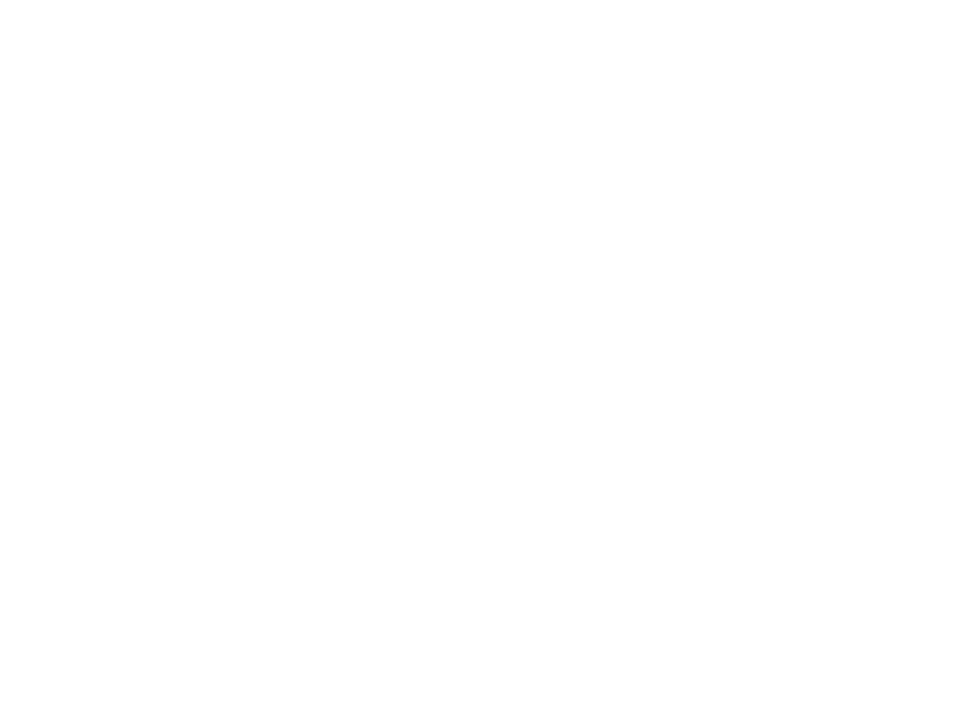

In [6]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

<IPython.core.display.Javascript object>


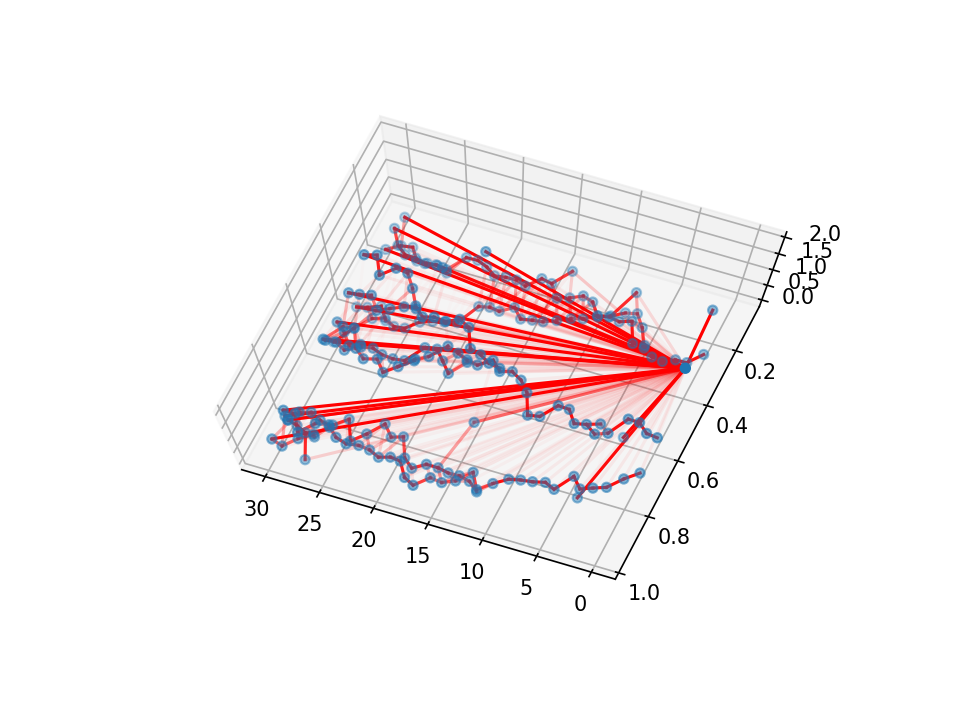

1.0 1.0
[2.0, 2.0]
2.0 1.0
[0.4107214428857715, 2.0]
2.0 7.0
[0.4107214428857715, 0.45449126012037855]
3.0 1.0
[0.29889779559118235, 2.0]
3.0 6.0
[0.29889779559118235, 0.2796841548485981]
4.0 1.0
[0.6614228456913828, 2.0]
4.0 8.0
[0.6614228456913828, 0.65450595269714]
5.0 1.0
[0.5711422845691382, 2.0]
6.0 1.0
[0.2796841548485981, 2.0]
6.0 9.0
[0.2796841548485981, 0.28665085168982135]
7.0 1.0
[0.45449126012037855, 2.0]
7.0 11.0
[0.45449126012037855, 0.43120399172250934]
8.0 1.0
[0.65450595269714, 2.0]
8.0 10.0
[0.65450595269714, 0.622973902369585]
9.0 1.0
[0.28665085168982135, 2.0]
9.0 12.0
[0.28665085168982135, 0.22217063650429164]
10.0 1.0
[0.622973902369585, 2.0]
10.0 14.0
[0.622973902369585, 0.6369582982766365]
11.0 1.0
[0.43120399172250934, 2.0]
11.0 13.0
[0.43120399172250934, 0.47584559799034926]
12.0 1.0
[0.22217063650429164, 2.0]
12.0 18.0
[0.22217063650429164, 0.2488754472585016]
13.0 1.0
[0.47584559799034926, 2.0]
13.0 16.0
[0.47584559799034926, 0.6169610268015229]
13.0 17.0
[

120.0 1.0
[0.6242882244813492, 2.0]
120.0 122.0
[0.6242882244813492, 0.6138293309490603]
120.0 125.0
[0.6242882244813492, 0.7815965937737284]
120.0 126.0
[0.6242882244813492, 0.4536843632426072]
121.0 1.0
[0.8363556964999542, 2.0]
121.0 125.0
[0.8363556964999542, 0.7815965937737284]
122.0 1.0
[0.6138293309490603, 2.0]
122.0 129.0
[0.6138293309490603, 0.671911507551714]
122.0 130.0
[0.6138293309490603, 0.5698168728118959]
122.0 135.0
[0.6138293309490603, 0.4466968797869196]
123.0 1.0
[0.3922419952806797, 2.0]
123.0 136.0
[0.3922419952806797, 0.43044158036985203]
123.0 137.0
[0.3922419952806797, 0.2912505887640172]
124.0 1.0
[0.18372922694989877, 2.0]
124.0 132.0
[0.18372922694989877, 0.11065868170447178]
124.0 133.0
[0.18372922694989877, 0.21945217959670604]
125.0 1.0
[0.7815965937737284, 2.0]
125.0 129.0
[0.7815965937737284, 0.671911507551714]
125.0 134.0
[0.7815965937737284, 0.766401016641603]
126.0 1.0
[0.4536843632426072, 2.0]
126.0 130.0
[0.4536843632426072, 0.5698168728118959]
126

In [9]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

run=7

x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)



#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    ax.plot3D(tline, yline, xline, c='red',alpha=w[i]/100)
    #ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

blue


<IPython.core.display.Javascript object>


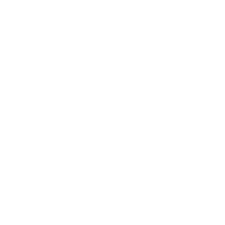

c_full ['blue', 'green', 'violet']


IndexError: list index out of range

In [8]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        return prev_c[int(ii-1)]
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0]
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id_f=[1,2,3]


print(c[id_f==1])


    


for t in range(31):
    
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
        ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

In [ ]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)